<img src="https://github.com/hernancontigiani/ceia_memorias_especializacion/raw/master/Figures/logoFIUBA.jpg" width="500" align="center">


# Procesamiento de lenguaje natural
## Custom embedddings con Gensim



### Objetivo
El objetivo es utilizar documentos / corpus para crear embeddings de palabras basado en ese contexto. Se utilizará canciones de bandas para generar los embeddings, es decir, que los vectores tendrán la forma en función de como esa banda haya utilizado las palabras en sus canciones.

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import multiprocessing
from gensim.models import Word2Vec

### Datos
Utilizaremos como dataset la biblia.

In [7]:
# Armar el dataset utilizando salto de línea para separar las oraciones/docs
df = pd.read_csv("/biblia.txt", sep = '/n', header = None)
df.head()

/usr/local/lib/python3.7/dist-packages/pandas/util/_decorators.py:311: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  return func(*args, **kwargs)


,0
0,In the beginning God created the heaven and th...
1,"And the earth was without form, and void; and ..."
2,"And God said, Let there be light: and there wa..."
3,"And God saw the light, that it was good: and G..."
4,"And God called the light Day, and the darkness..."


In [8]:
print("Cantidad de documentos:", df.shape[0])

Cantidad de documentos: 31102


### 1 - Preprocesamiento

In [9]:
from keras.preprocessing.text import text_to_word_sequence

sentence_tokens = []
# Recorrer todas las filas y transformar las oraciones
# en una secuencia de palabras (esto podría realizarse con NLTK o spaCy también)
for _, row in df[:None].iterrows():
    sentence_tokens.append(text_to_word_sequence(row[0]))

In [10]:
# Demos un vistazo
sentence_tokens[:2]

[['in',
  'the',
  'beginning',
  'god',
  'created',
  'the',
  'heaven',
  'and',
  'the',
  'earth'],
 ['and',
  'the',
  'earth',
  'was',
  'without',
  'form',
  'and',
  'void',
  'and',
  'darkness',
  'was',
  'upon',
  'the',
  'face',
  'of',
  'the',
  'deep',
  'and',
  'the',
  'spirit',
  'of',
  'god',
  'moved',
  'upon',
  'the',
  'face',
  'of',
  'the',
  'waters']]

### 2 - Crear los vectores (word2vec)

In [11]:
from gensim.models.callbacks import CallbackAny2Vec
# Durante el entrenamiento gensim por defecto no informa el "loss" en cada época
# Sobracargamos el callback para poder tener esta información
class callback(CallbackAny2Vec):
    """
    Callback to print loss after each epoch
    """
    def __init__(self):
        self.epoch = 0

    def on_epoch_end(self, model):
        loss = model.get_latest_training_loss()
        if self.epoch == 0:
            r = loss
            print('Loss after epoch {}: {}'.format(self.epoch, r))
        else:
            r = loss - self.loss_previous_step
            print('Loss after epoch {}: {}'.format(self.epoch, r))
        self.epoch += 1
        self.loss_previous_step = loss

In [12]:
# Crearmos el modelo generador de vectoeres
# En este caso utilizaremos la estructura modelo Skipgram
w2v_model = Word2Vec(min_count = 5,    # frecuencia mínima de palabra para incluirla en el vocabulario
                     window = 3,       # cant de palabras antes y desp de la predicha
                     size = 100,       # dimensionalidad de los vectores 
                     negative = 24,    # cantidad de negative samples... 0 es no se usa
                     workers = 1,      # si tienen más cores pueden cambiar este valor
                     sg = 1)           # modelo 0:CBOW  1:skipgram

In [13]:
# Buildear el vocabularui con los tokens
w2v_model.build_vocab(sentence_tokens)

In [14]:
# Cantidad de filas/docs encontradas en el corpus
print("Cantidad de docs en el corpus:", w2v_model.corpus_count)

Cantidad de docs en el corpus: 31102


In [15]:
# Cantidad de words encontradas en el corpus
print("Cantidad de words distintas en el corpus:", len(w2v_model.wv.vocab))

Cantidad de words distintas en el corpus: 5332


### 3 - Entrenar el modelo generador

In [17]:
# Entrenamos el modelo generador de vectores
# Utilizamos nuestro callback
loss_vector = w2v_model.train(sentence_tokens,
                 total_examples = w2v_model.corpus_count,
                 epochs = 200,
                 compute_loss = True,
                 callbacks=[callback()]
                 )

Loss after epoch 0: 5577854.0
Loss after epoch 1: 4924120.0
Loss after epoch 2: 4735857.0
Loss after epoch 3: 4594251.0
Loss after epoch 4: 4493692.0
Loss after epoch 5: 4462192.0
Loss after epoch 6: 4442724.0
Loss after epoch 7: 4478658.0
Loss after epoch 8: 4466788.0
Loss after epoch 9: 4437432.0
Loss after epoch 10: 4428156.0
Loss after epoch 11: 4406500.0
Loss after epoch 12: 4404056.0
Loss after epoch 13: 4398252.0
Loss after epoch 14: 3381860.0
Loss after epoch 15: 1523936.0
Loss after epoch 16: 1516256.0
Loss after epoch 17: 1516808.0
Loss after epoch 18: 1516592.0
Loss after epoch 19: 1513360.0
Loss after epoch 20: 1511968.0
Loss after epoch 21: 1504816.0
Loss after epoch 22: 1503640.0
Loss after epoch 23: 1502784.0
Loss after epoch 24: 1499280.0
Loss after epoch 25: 1499592.0
Loss after epoch 26: 1499256.0
Loss after epoch 27: 1494104.0
Loss after epoch 28: 1486880.0
Loss after epoch 29: 1493360.0
Loss after epoch 30: 1488640.0
Loss after epoch 31: 1484280.0
Loss after epoch 3

In [41]:
loss = pd.read_excel('/loss.xlsx', header = None)

In [42]:
loss

,0,1
0,0,5577854.0
1,1,4924120.0
2,2,4735857.0
3,3,4594251.0
4,4,4493692.0
...,...,...
195,195,0.0
196,196,0.0
197,197,0.0
198,198,0.0


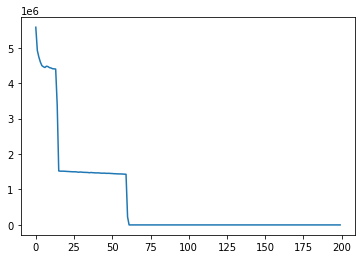

In [44]:
import matplotlib.pyplot as plt

plt.plot(loss.iloc[:, 0], loss.iloc[:, 1])
plt.show()

### 4 - Ensayar

In [25]:
# Palabras que MÁS se relacionan con...:
word = 'god'
w2v_model.wv.most_similar(positive = [word], topn = 10)

[('lord', 0.7769405841827393),
 ('hosts', 0.5713472366333008),
 ('jesus', 0.5349681973457336),
 ('almighty', 0.49854913353919983),
 ('glory', 0.48833733797073364),
 ('spirit', 0.4875530004501343),
 ('faith', 0.48331549763679504),
 ('redeemer', 0.4793400764465332),
 ('christ', 0.4757547378540039),
 ('me', 0.4742594361305237)]

In [26]:
# Palabras que MENOS se relacionan con...:
word = 'god'
w2v_model.wv.most_similar(negative = [word], topn = 10)

[('lice', 0.16925495862960815),
 ('nurse', 0.09300833940505981),
 ('garrisons', 0.08236730098724365),
 ('plucked', 0.07871416211128235),
 ('encamped', 0.0710039883852005),
 ('seeking', 0.06413640081882477),
 ('cloth', 0.06260058283805847),
 ('bethhoron', 0.06221367418766022),
 ('passeth', 0.06143920496106148),
 ('bulls', 0.0602596178650856)]

In [29]:
# Palabras que MÁS se relacionan con...:
word = 'jesus'
w2v_model.wv.most_similar(positive = [word], topn = 10)

[('peter', 0.5819089412689209),
 ('nazareth', 0.5630572438240051),
 ('john', 0.5586867928504944),
 ('god', 0.5349681973457336),
 ('christ', 0.5289278626441956),
 ('simon', 0.5039030909538269),
 ('pilate', 0.5003295540809631),
 ('philip', 0.49475526809692383),
 ('nathanael', 0.49114060401916504),
 ('paul', 0.4840681254863739)]

In [46]:
# Palabras que MÁS se relacionan con...:
word = 'good'
w2v_model.wv.most_similar(positive = [word], topn = 10)

[('lawful', 0.5267466902732849),
 ('honest', 0.48559245467185974),
 ('plainly', 0.44527167081832886),
 ('truth', 0.4368925094604492),
 ('evil', 0.43608248233795166),
 ('abominable', 0.4263128638267517),
 ('perfect', 0.4258212447166443),
 ('giveth', 0.4226614832878113),
 ('moving', 0.41730013489723206),
 ('well', 0.4163033962249756)]

In [50]:
# Palabras que MÁS se relacionan con...:
word = 'evil'
w2v_model.wv.most_similar(positive = [word], topn = 10)

[('wicked', 0.5175818204879761),
 ('murmurings', 0.4907613694667816),
 ('wickedness', 0.4798751473426819),
 ('imagine', 0.47690853476524353),
 ('iniquity', 0.4750189185142517),
 ('blasphemies', 0.47287869453430176),
 ('hate', 0.4585634469985962),
 ('devise', 0.4580485224723816),
 ('diseases', 0.45149338245391846),
 ('lewdness', 0.44917285442352295)]

In [33]:
# Palabras que MÁS se relacionan con...:
word = 'sin'
w2v_model.wv.most_similar(positive = [word], topn = 10)

[('trespass', 0.6347157955169678),
 ('sinned', 0.5300602316856384),
 ('sins', 0.515604555606842),
 ('atonement', 0.4804205000400543),
 ('sinneth', 0.47933313250541687),
 ('transgression', 0.4701286554336548),
 ('iniquity', 0.46968311071395874),
 ('sacrifice', 0.4633431136608124),
 ('savour', 0.46213674545288086),
 ('offering', 0.4603453576564789)]

In [30]:
# Ensayar con una palabra que no está en el corpus (en vocab):
word = 'python'
w2v_model.wv.most_similar(negative = [word])

KeyError: ignored

### 5 - Visualizar agrupación de vectores

In [34]:
from sklearn.decomposition import IncrementalPCA    
from sklearn.manifold import TSNE                   
import numpy as np                                  

def reduce_dimensions(model):
    num_dimensions = 2  

    vectors = np.asarray(model.wv.vectors)
    labels = np.asarray(model.wv.index2word)  

    tsne = TSNE(n_components=num_dimensions, random_state=0)
    vectors = tsne.fit_transform(vectors)

    x_vals = [v[0] for v in vectors]
    y_vals = [v[1] for v in vectors]
    return x_vals, y_vals, labels

In [36]:
# Graficar los embedddings en 2D
import plotly.graph_objects as go
import plotly.express as px

x_vals, y_vals, labels = reduce_dimensions(w2v_model)

MAX_WORDS = 50
fig = px.scatter(x=x_vals[:MAX_WORDS], y=y_vals[:MAX_WORDS], text=labels[:MAX_WORDS])
fig.show(renderer="colab") # esto para plotly en colab

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning:

The default initialization in TSNE will change from 'random' to 'pca' in 1.2.

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning:

The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.



In [45]:
# Graficar los embedddings en 2D
import plotly.graph_objects as go
import plotly.express as px

x_vals, y_vals, labels = reduce_dimensions(w2v_model)

MAX_WORDS = 200
fig = px.scatter(x=x_vals[:MAX_WORDS], y=y_vals[:MAX_WORDS], text=labels[:MAX_WORDS])
fig.show(renderer="colab") # esto para plotly en colab

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning:

The default initialization in TSNE will change from 'random' to 'pca' in 1.2.

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning:

The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.



### Explicación y conclusiones

Se quiso buscar un corpus extenso y de gran popularidad, así que se utilizó la Biblia. Se procesó un poco el archivo en excel, en donde se quitaron índices, enlaces, y espacios; luego se carg[o al Drive. Se utilizó skipgram y se testearon diferentes parámetros para entrenar el un modelo. El que mejor perfomó fue el de 200 épocas y 100 dimensiones de embedding, en donde se logró un loss en entrenamiento de 0. Para lograr graficar el loss, se importó una tabla con los errores impresos en pantalla, porque se intentó por varias maneras guardar los valores en un vector, pero la función hace cosas por debajo que no se comprenden, así que se copiaron y pegaron estos valores en un dataset y se los graficó.

Se testearon las palabras más típicas y los resultados fueron muy coherentes. Por ejemplo para la palabra 'god', las 10 palabras más parecidos tuvieron mucho sentido. Dentro de ellas figuran 'lord', 'jesus', 'almighty', 'christ', por nombrar algunas. Sin embargo, las palabras menos relacionadas no parecían estar conectadas en sentido contrario ('lice', 'nurse'). Es más esperable que las palabras con mayor relación resuleten más razonables. La palabra 'jesus', por mencionar otro ejemplo, se relaciona con 'nazareth', cosa que es muy entendible. Siguiendo con más ejemplos, la palabra 'good' se relaciona con valores positivos: 'lawful', 'honest', 'truth', 'perfect', 'well'. Pero dentro de las más relacionadas también se encuentran los antónimos, como 'evil' y 'abominable'. Que ocurra esto es muy esperable, puesto que 'good' y 'evil' tienden a aparecer juntas y el modelo las relaciona. También se evaluaron similitudes con 'evil' y 'sin' y los resultados fueron muy acerttados, mostrando palabras negativas. 

Luego se graficaron los embeddings en 2D, con 50 y 200 palabras. Se pueden ver buenas relaciones, como la cercanía entre 'sons' y 'children'; 'god' y 'lord', 'good' y 'evil', 'heaven y earth', 'king' y 'priest', y 'god' con 'spirit' y 'heart'. tra cuestión a mencionar es la cercanía entre las palabras 'shall' y 'be' que se ve en el gráfico. Esto ocure porque ambas palabras aparecen numerosas vences juntas como 'shall be'.

Hay muchas palabras muy genéricas con poco contenido que figuran, como 'is', 'are', 'if'. Estas palabras pueden filtrarse para quedarse con palabras con significados más ricos.

### Alumno

- Crear sus propios vectores con Gensim basado en lo visto en clase con otro dataset.
- Probar términos de interés y explicar similitudes en el espacio de embeddings (sacar conclusiones entre palabras similitudes y diferencias).
- Graficarlos.
- Obtener conclusiones.